In [63]:
import pandas as pd
from pathlib import Path
import time
from tqdm.notebook import tqdm
import numpy as np
import neptune
import datetime

In [73]:
args = {}
args['data_folder'] = './Data'
args['data_filename'] = 'full_data_2014to2021.pkl'
args['summarize_n_games']= 5
args['columns_to_summarize']=['Pace', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'ORtg', 'TS%', 
                              '3PAr', 'FTr', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'DRtg']
args['summarize_method']='mean'
args['columns_order'] = ['DATE', 'VISITOR', 'VISITOR_PTS', 'HOME', 'HOME_PTS', 'boxscores_url',
                         'game_id', 'Pace_home', 'eFG%_home', 'TOV%_home', 'ORB%_home',
                         'FT/FGA_home', 'ORtg_home', 'TS%_home', '3PAr_home', 'FTr_home', 
                         'DRB%_home', 'TRB%_home','AST%_home', 'STL%_home', 'BLK%_home', 'DRtg_home',
                         'Pace_visitor', 'eFG%_visitor','TOV%_visitor', 'ORB%_visitor', 
                         'FT/FGA_visitor', 'ORtg_visitor','TS%_visitor',
                         '3PAr_visitor', 'FTr_visitor', 'DRB%_visitor', 'TRB%_visitor',
                         'AST%_visitor', 'STL%_visitor', 'BLK%_visitor', 'DRtg_visitor',
                         'TOTAL_PTS', 'HOME_VISITOR_PTS_DIFF', 'HOME_WIN']

args['home_columns_to_summarize']=[column + '_'+'home' for column in args['columns_to_summarize']]
args['visitor_columns_to_summarize']=[column + '_'+'visitor' for column in args['columns_to_summarize']]
args['processed_dataset_filename']= f"ProcessedDataset_TeamBasis_{args['summarize_method']}_Past{args['summarize_n_games']}Games_{datetime.date.today()}.pkl"

args['random_state']=248 # RIP Kobe

In [23]:
data_folder = Path(args['data_folder'])
assert data_folder.exists()

# Read Raw Data

In [24]:
dataset_df = pd.read_pickle(data_folder/args['data_filename'])
dataset_df.head()

,DATE,VISITOR,VISITOR_PTS,HOME,HOME_PTS,boxscores_url,game_id,Pace_home,eFG%_home,TOV%_home,...,DRtg_home,TS%_visitor,3PAr_visitor,FTr_visitor,DRB%_visitor,TRB%_visitor,AST%_visitor,STL%_visitor,BLK%_visitor,DRtg_visitor
0,2013-10-29,ORL,87,IND,97,https://www.basketball-reference.com/boxscores...,201310290IND,95.0,0.528,19.0,...,91.6,.447,.204,.108,72.2,47.0,47.2,10.5,11.1,102.1
1,2013-10-29,CHI,95,MIA,107,https://www.basketball-reference.com/boxscores...,201310290MIA,97.1,0.590,17.5,...,97.9,.510,.313,.277,85.7,50.6,65.7,11.3,7.7,110.2
2,2013-10-29,LAC,103,LAL,116,https://www.basketball-reference.com/boxscores...,201310290LAL,100.4,0.527,15.3,...,102.6,.553,.253,.277,62.5,43.5,65.9,11.0,6.3,115.6
3,2013-10-30,BRK,94,CLE,98,https://www.basketball-reference.com/boxscores...,201310300CLE,92.3,0.446,10.0,...,101.8,.508,.293,.293,63.6,43.5,72.7,8.7,11.6,106.2
4,2013-10-30,BOS,87,TOR,93,https://www.basketball-reference.com/boxscores...,201310300TOR,91.5,0.471,15.0,...,95.1,.552,.197,.439,57.8,40.7,46.9,10.9,10.1,101.6


In [25]:
# convert string columns to numeric columns
for column in ['VISITOR_PTS','HOME_PTS']:
    dataset_df[column] = pd.to_numeric(dataset_df[column])

In [47]:
numeric_col=[]
for col_name in args['columns_to_summarize']:
    numeric_col.append(col_name+'_home')
    numeric_col.append(col_name+'_visitor')
numeric_col

['Pace_home',
 'Pace_visitor',
 'eFG%_home',
 'eFG%_visitor',
 'TOV%_home',
 'TOV%_visitor',
 'ORB%_home',
 'ORB%_visitor',
 'FT/FGA_home',
 'FT/FGA_visitor',
 'ORtg_home',
 'ORtg_visitor',
 'TS%_home',
 'TS%_visitor',
 '3PAr_home',
 '3PAr_visitor',
 'FTr_home',
 'FTr_visitor',
 'DRB%_home',
 'DRB%_visitor',
 'TRB%_home',
 'TRB%_visitor',
 'AST%_home',
 'AST%_visitor',
 'STL%_home',
 'STL%_visitor',
 'BLK%_home',
 'BLK%_visitor',
 'DRtg_home',
 'DRtg_visitor']

In [51]:
dataset_df[numeric_col]

,Pace_home,Pace_visitor,eFG%_home,eFG%_visitor,TOV%_home,TOV%_visitor,ORB%_home,ORB%_visitor,FT/FGA_home,FT/FGA_visitor,...,TRB%_home,TRB%_visitor,AST%_home,AST%_visitor,STL%_home,STL%_visitor,BLK%_home,BLK%_visitor,DRtg_home,DRtg_visitor
0,95.0,95.0,0.528,0.435,19.0,14.9,27.8,27.7,0.310,0.065,...,53.0,47.0,50.0,47.2,4.2,10.5,24.3,11.1,91.6,102.1
1,97.1,97.1,0.590,0.464,17.5,16.2,14.3,23.9,0.306,0.217,...,49.4,50.6,70.3,65.7,10.3,11.3,12.3,7.7,97.9,110.2
2,100.4,100.4,0.527,0.542,15.3,14.7,37.5,22.7,0.194,0.157,...,56.5,43.5,54.8,65.9,8.0,11.0,9.7,6.3,102.6,115.6
3,92.5,92.5,0.457,0.462,13.3,17.2,25.0,21.1,0.198,0.190,...,50.0,50.0,39.4,55.9,8.6,3.2,10.9,18.3,95.1,97.3
4,92.4,92.4,0.542,0.457,14.2,12.4,28.2,23.4,0.169,0.210,...,54.7,45.3,41.9,57.6,8.7,5.4,9.1,7.8,98.5,112.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8738,104.2,104.2,0.695,0.500,16.0,13.4,25.7,23.3,0.244,0.247,...,53.8,46.2,61.2,64.3,7.7,10.6,11.8,13.2,111.3,128.6
8739,96.4,96.4,0.548,0.542,10.6,13.5,13.3,28.6,0.193,0.238,...,41.4,58.6,78.9,41.0,9.3,3.1,8.0,8.7,115.1,111.0
8740,98.7,98.7,0.539,0.602,14.4,10.5,20.9,14.0,0.135,0.277,...,53.5,46.5,58.5,80.0,4.1,14.2,10.5,7.8,124.6,109.4
8741,99.9,99.9,0.652,0.530,15.0,7.0,17.6,22.4,0.266,0.152,...,53.0,47.0,55.6,46.7,6.0,12.0,6.3,10.4,120.1,124.1


In [53]:
dataset_df[numeric_col] = dataset_df[numeric_col].astype('float')

In [54]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8743 entries, 0 to 8742
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   DATE                   8743 non-null   datetime64[ns]
 1   VISITOR                8743 non-null   object        
 2   VISITOR_PTS            8743 non-null   float64       
 3   HOME                   8743 non-null   object        
 4   HOME_PTS               8743 non-null   float64       
 5   boxscores_url          8743 non-null   object        
 6   game_id                8743 non-null   object        
 7   Pace_home              8743 non-null   float64       
 8   eFG%_home              8743 non-null   float64       
 9   TOV%_home              8743 non-null   float64       
 10  ORB%_home              8743 non-null   float64       
 11  FT/FGA_home            8743 non-null   float64       
 12  ORtg_home              8743 non-null   float64       
 13  TS%

In [55]:
dataset_df.columns

Index(['DATE', 'VISITOR', 'VISITOR_PTS', 'HOME', 'HOME_PTS', 'boxscores_url',
       'game_id', 'Pace_home', 'eFG%_home', 'TOV%_home', 'ORB%_home',
       'FT/FGA_home', 'ORtg_home', 'TS%_home', '3PAr_home', 'FTr_home',
       'DRB%_home', 'TRB%_home', 'AST%_home', 'STL%_home', 'BLK%_home',
       'DRtg_home', 'Pace_visitor', 'eFG%_visitor', 'TOV%_visitor',
       'ORB%_visitor', 'FT/FGA_visitor', 'ORtg_visitor', 'TS%_visitor',
       '3PAr_visitor', 'FTr_visitor', 'DRB%_visitor', 'TRB%_visitor',
       'AST%_visitor', 'STL%_visitor', 'BLK%_visitor', 'DRtg_visitor',
       'TOTAL_PTS', 'HOME_VISITOR_PTS_DIFF', 'HOME_WIN'],
      dtype='object')

In [39]:
dataset_df = dataset_df[args['columns_order']]

In [40]:
dataset_df['TOTAL_PTS'] = dataset_df['VISITOR_PTS']+dataset_df['HOME_PTS']
dataset_df['HOME_VISITOR_PTS_DIFF'] = dataset_df['HOME_PTS']-dataset_df['VISITOR_PTS']
dataset_df['HOME_WIN'] = (dataset_df['HOME_VISITOR_PTS_DIFF']>0)

# Models

## Team based - simple average of past xx games


### Data Processing

In [ ]:
# get most recent x games data as training data
# test on 2021 data
    # sort by dates
    # iterate rows
    # get current index
    # from current index, go backwards index until found previous X games
        # if out of index before fetching X games, stop and continue (give up predicting this game)
    # if HOME or VISITOR equals to current row HOME, then get that row
    # save into a dictionary, key is game_id
    # transform as data frame, and join with the full data
# average
# 2 teams, concatenate to the same row
# predict

In [41]:
def strip_col_suffix(df):
    """
    strip the '_home' or '_visitor' suffix from the stats columns, using args
    """
    rename_dict = {old_col:new_col for old_col,new_col in zip(args['home_columns_to_summarize']+args['visitor_columns_to_summarize'],args['columns_to_summarize']*2)}
    return df.rename(columns=rename_dict)

def get_previous_games(curr_row_index,team_name,dataset_df:pd.DataFrame,previous_n=args['summarize_n_games'])->list:
    """
    return a list of pandas dataframes of previous of games, regardless of home or away.
    """
    previous_games = []
    # start iterating previous games
    for index in range(curr_row_index-1,-1,-1):
        try:
            # if home team matches
            if (dataset_df.loc[index]['HOME']==team_name):
                previous_game=dataset_df.loc[[index]][args['home_columns_to_summarize']]
                previous_games.append(strip_col_suffix(previous_game))
            # if visitor team matches
            if (dataset_df.loc[index]['VISITOR']==team_name):
                previous_game=dataset_df.loc[[index]][args['visitor_columns_to_summarize']]
                previous_games.append(strip_col_suffix(previous_game))
            # stop when we have enough games
            if len(previous_games)==previous_n:
                break
        except Exception as exc:
            print(exc)
    if len(previous_games)<args['summarize_n_games']:
        raise ValueError(f"Less than {args['summarize_n_games']} previous games.")
    # return a list of dataframes
    return previous_games

def summarize_previous_games(curr_row_index,team_name,original_df,previous_n=args['summarize_n_games'],summarize_method=args['summarize_method'],summarize_func=None)->pd.DataFrame:
    """
    calculate previous games' stats using `method`
    `previous_n`: number of previous games
    `summarize_method`: method to summarize prevous games
    """

    previous_games = get_previous_games(curr_row_index,team_name,original_df,previous_n)
    # concat return dataframes into one dataframe
    previous_games = pd.concat(previous_games)
    if summarize_func:
        return summarize_func(previous_games)
    if summarize_method == 'mean':
        return np.mean(previous_games,axis=0)
    if summarize_method == 'median':
            return np.median(previous_games,axis=0)

In [56]:
#TODO: use dataclass
dataset_df = dataset_df.sort_values(by='DATE').reset_index(drop=True)
games_summaries=[]
bad_index=[]
for index,row in tqdm(dataset_df.iterrows(),total=dataset_df.shape[0]):
    try:
        # home team summary
        summarized_home = summarize_previous_games(index, row['HOME'],dataset_df, args['summarize_n_games']).to_dict()
        summarized_home['Team'] = row['HOME']
        summarized_home['game_id'] = row['game_id']
        games_summaries.append(summarized_home)

        # visitor team summary
        summarized_visitor = summarize_previous_games(index, row['VISITOR'],dataset_df, args['summarize_n_games']).to_dict()
        summarized_visitor['Team'] = row['VISITOR']
        summarized_visitor['game_id'] = row['game_id']
        games_summaries.append(summarized_visitor)
    except Exception as exc:
        print(f"bad index {index}, error: {exc}")
        print('-'*100)
        bad_index.append(index)

    

bad index 0, error: Less than 5 previous games.
----------------------------------------------------------------------------------------------------
bad index 1, error: Less than 5 previous games.
----------------------------------------------------------------------------------------------------
bad index 2, error: Less than 5 previous games.
----------------------------------------------------------------------------------------------------
bad index 3, error: Less than 5 previous games.
----------------------------------------------------------------------------------------------------
bad index 4, error: Less than 5 previous games.
----------------------------------------------------------------------------------------------------
bad index 5, error: Less than 5 previous games.
----------------------------------------------------------------------------------------------------
bad index 6, error: Less than 5 previous games.
----------------------------------------------------------

bad index 57, error: Less than 5 previous games.
----------------------------------------------------------------------------------------------------
bad index 58, error: Less than 5 previous games.
----------------------------------------------------------------------------------------------------
bad index 59, error: Less than 5 previous games.
----------------------------------------------------------------------------------------------------
bad index 60, error: Less than 5 previous games.
----------------------------------------------------------------------------------------------------
bad index 61, error: Less than 5 previous games.
----------------------------------------------------------------------------------------------------
bad index 62, error: Less than 5 previous games.
----------------------------------------------------------------------------------------------------
bad index 63, error: Less than 5 previous games.
---------------------------------------------------

In [57]:
len(games_summaries)

17326

In [58]:
games_summaries[0]

{'Pace': 96.7,
 'eFG%': 0.5558,
 'TOV%': 16.98,
 'ORB%': 32.239999999999995,
 'FT/FGA': 0.3586,
 'ORtg': 113.12,
 'TS%': 0.6016,
 '3PAr': 0.33039999999999997,
 'FTr': 0.5027999999999999,
 'DRB%': 74.08,
 'TRB%': 56.0,
 'AST%': 47.4,
 'STL%': 6.959999999999999,
 'BLK%': 7.140000000000001,
 'DRtg': 106.88000000000002,
 'Team': 'HOU',
 'game_id': '201311070HOU'}

In [60]:
games_summaries_df = pd.DataFrame(games_summaries)
games_summaries_df

,Pace,eFG%,TOV%,ORB%,FT/FGA,ORtg,TS%,3PAr,FTr,DRB%,TRB%,AST%,STL%,BLK%,DRtg,Team,game_id
0,96.70,0.5558,16.98,32.24,0.3586,113.12,0.6016,0.3304,0.5028,74.08,56.00,47.40,6.96,7.14,106.88,HOU,201311070HOU
1,100.26,0.4738,12.98,20.76,0.1930,100.50,0.5104,0.2952,0.2654,77.82,48.18,61.46,6.20,8.48,108.64,LAL,201311070HOU
2,92.82,0.5738,15.48,19.00,0.2518,113.12,0.6106,0.3242,0.3296,71.34,45.70,75.76,9.30,7.08,107.34,MIA,201311070MIA
3,98.74,0.5342,12.76,27.82,0.2716,114.66,0.5730,0.3058,0.3740,72.66,49.70,65.48,9.18,8.32,111.04,LAC,201311070MIA
4,90.66,0.4498,12.26,26.94,0.2814,99.76,0.4948,0.2078,0.4282,72.56,49.26,54.54,8.12,10.48,104.34,CHA,201311080CHA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17321,97.04,0.5358,9.56,23.78,0.1576,117.48,0.5672,0.4588,0.1836,75.34,48.18,43.96,7.46,10.14,123.30,POR,202102020WAS
17322,98.14,0.5526,13.78,24.12,0.2270,114.60,0.5926,0.4020,0.2754,74.42,51.14,65.78,5.86,13.04,112.90,IND,202102020IND
17323,99.72,0.5676,9.98,24.40,0.1314,119.22,0.5864,0.3100,0.1810,75.42,50.38,68.46,11.42,10.90,106.16,MEM,202102020IND
17324,95.96,0.5460,10.72,29.58,0.2560,122.54,0.5934,0.5368,0.3046,85.04,56.48,63.50,6.26,9.00,111.64,UTA,202102020UTA


In [61]:
temp_home = pd.merge(dataset_df[['DATE','VISITOR', 'VISITOR_PTS', 'HOME', 'HOME_PTS', 'boxscores_url','game_id']],games_summaries_df,left_on=['game_id','HOME'],right_on=['game_id','Team'])
processed_dataset=pd.merge(temp_home,games_summaries_df,left_on=['game_id','VISITOR'],right_on=['game_id','Team'],suffixes=('_home','_visitor'))
processed_dataset['TOTAL_PTS'] = processed_dataset['VISITOR_PTS']+processed_dataset['HOME_PTS']
processed_dataset['HOME_VISITOR_PTS_DIFF'] = processed_dataset['HOME_PTS']-processed_dataset['VISITOR_PTS']
processed_dataset['HOME_WIN'] = (processed_dataset['HOME_VISITOR_PTS_DIFF']>0)

In [62]:
processed_dataset

,DATE,VISITOR,VISITOR_PTS,HOME,HOME_PTS,boxscores_url,game_id,Pace_home,eFG%_home,TOV%_home,...,DRB%_visitor,TRB%_visitor,AST%_visitor,STL%_visitor,BLK%_visitor,DRtg_visitor,Team_visitor,TOTAL_PTS,HOME_VISITOR_PTS_DIFF,HOME_WIN
0,2013-11-07,LAL,99.0,HOU,98.0,https://www.basketball-reference.com/boxscores...,201311070HOU,96.70,0.5558,16.98,...,77.82,48.18,61.46,6.20,8.48,108.64,LAL,197.0,-1.0,False
1,2013-11-07,LAC,97.0,MIA,102.0,https://www.basketball-reference.com/boxscores...,201311070MIA,92.82,0.5738,15.48,...,72.66,49.70,65.48,9.18,8.32,111.04,LAC,199.0,5.0,True
2,2013-11-08,TOR,84.0,IND,91.0,https://www.basketball-reference.com/boxscores...,201311080IND,93.20,0.5100,16.92,...,79.24,55.14,47.62,5.68,5.86,105.90,TOR,175.0,7.0,True
3,2013-11-08,BOS,91.0,ORL,89.0,https://www.basketball-reference.com/boxscores...,201311080ORL,96.76,0.5240,14.96,...,68.10,47.88,46.18,9.60,8.18,102.30,BOS,180.0,-2.0,False
4,2013-11-08,CLE,79.0,PHI,94.0,https://www.basketball-reference.com/boxscores...,201311080PHI,102.72,0.5140,16.50,...,78.14,50.76,50.14,10.78,6.22,100.62,CLE,173.0,15.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8656,2021-02-02,BOS,111.0,GSW,107.0,https://www.basketball-reference.com/boxscores...,202102020GSW,101.74,0.5562,12.96,...,74.98,49.88,53.08,10.78,11.14,108.86,BOS,218.0,-4.0,False
8657,2021-02-02,LAC,120.0,BRK,124.0,https://www.basketball-reference.com/boxscores...,202102020BRK,100.88,0.6076,10.54,...,78.22,50.76,60.36,7.46,6.70,108.22,LAC,244.0,4.0,True
8658,2021-02-02,POR,132.0,WAS,121.0,https://www.basketball-reference.com/boxscores...,202102020WAS,102.34,0.4752,11.16,...,75.34,48.18,43.96,7.46,10.14,123.30,POR,253.0,-11.0,False
8659,2021-02-02,MEM,116.0,IND,134.0,https://www.basketball-reference.com/boxscores...,202102020IND,98.14,0.5526,13.78,...,75.42,50.38,68.46,11.42,10.90,106.16,MEM,250.0,18.0,True


In [75]:
# TODO: automatically populate dataset name, model name
processed_dataset.to_pickle(data_folder/(args['processed_dataset_filename']))

# Generate Training/Validation/Test Data

In [76]:
# import libraries
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from dtreeviz.trees import *

/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [77]:
# load the processed data
teamstats = pd.read_pickle(data_folder/(args['processed_dataset_filename']))
teamstats = add_datepart(teamstats, 'DATE')
teamstats.columns

Index(['VISITOR', 'VISITOR_PTS', 'DATEWeek', 'HOME', 'HOME_PTS',
       'boxscores_url', 'game_id', 'Pace_home', 'eFG%_home', 'TOV%_home',
       'ORB%_home', 'FT/FGA_home', 'ORtg_home', 'TS%_home', '3PAr_home',
       'FTr_home', 'DRB%_home', 'TRB%_home', 'AST%_home', 'STL%_home',
       'BLK%_home', 'DRtg_home', 'Team_home', 'Pace_visitor', 'eFG%_visitor',
       'TOV%_visitor', 'ORB%_visitor', 'FT/FGA_visitor', 'ORtg_visitor',
       'TS%_visitor', '3PAr_visitor', 'FTr_visitor', 'DRB%_visitor',
       'TRB%_visitor', 'AST%_visitor', 'STL%_visitor', 'BLK%_visitor',
       'DRtg_visitor', 'Team_visitor', 'TOTAL_PTS', 'HOME_VISITOR_PTS_DIFF',
       'HOME_WIN', 'DATEYear', 'DATEMonth', 'DATEDay', 'DATEDayofweek',
       'DATEDayofyear', 'DATEIs_month_end', 'DATEIs_month_start',
       'DATEIs_quarter_end', 'DATEIs_quarter_start', 'DATEIs_year_end',
       'DATEIs_year_start', 'DATEElapsed'],
      dtype='object')

In [81]:
# teamstats['DRtg_home']=100
# teamstats['DRtg_visitor']=100

In [80]:
# set what are dependent variables, what are independent variables
args['dep_variable'] = ['HOME_VISITOR_PTS_DIFF']
args['ind_variable'] = args['home_columns_to_summarize']+args['visitor_columns_to_summarize']

In [82]:
other_idx,test_idx = train_test_split(list(teamstats.index),test_size=0.1,random_state=args['random_state'])
test_set = teamstats.loc[test_idx,args['ind_variable']+args['dep_variable']].copy()
# don't want to mix non-test set with training set, therefore "other_set"
other_set = teamstats.loc[other_idx,args['ind_variable']+args['dep_variable']].copy()
train_idx,valid_idx = train_test_split(list(other_set.reset_index(drop=True).index),test_size=0.2,random_state=args['random_state'])
[len(idx) for idx in [train_idx,valid_idx,test_idx]]

[6235, 1559, 867]

In [83]:
# split continuous variables and categorical variabls
cont_var, cat_var=cont_cat_split(other_set,1,dep_var=args['dep_variable'])
print(cont_var,cat_var)

['Pace_home', 'eFG%_home', 'TOV%_home', 'ORB%_home', 'FT/FGA_home', 'ORtg_home', 'TS%_home', '3PAr_home', 'FTr_home', 'DRB%_home', 'TRB%_home', 'AST%_home', 'STL%_home', 'BLK%_home', 'DRtg_home', 'Pace_visitor', 'eFG%_visitor', 'TOV%_visitor', 'ORB%_visitor', 'FT/FGA_visitor', 'ORtg_visitor', 'TS%_visitor', '3PAr_visitor', 'FTr_visitor', 'DRB%_visitor', 'TRB%_visitor', 'AST%_visitor', 'STL%_visitor', 'BLK%_visitor', 'DRtg_visitor'] []


In [84]:
# return a tabular object
to=TabularPandas(other_set,cat_names=cat_var,cont_names=cont_var,
                 y_names=args['dep_variable'],splits=(train_idx,valid_idx))
len(to.train),len(to.valid)

(6235, 1559)

In [85]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
print(len(xs))
print(len(valid_xs))

6235
1559


# Initialize Neptune to Record Experiments

In [96]:
neptune.init(project_qualified_name='jjnotjimmyjohn/NBA-Score-Prediction',api_token=neptune.ANONYMOUS_API_TOKEN)
# neptune.init(project_qualified_name='jjnotjimmyjohn/sandbox',api_token=neptune.ANONYMOUS_API_TOKEN)

Forbidden: You have no permissions to access this resource.

# Decision Tree

In [88]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import scipy.stats as stats
from sklearn.metrics import SCORERS

In [89]:
# parameters distribution to randomized search
dt_params_dist={
    'min_samples_split':[5,10,15,20],
    'min_samples_leaf':[10,20,30,40,60],
    'max_features':[0.5,0.6,0.7,0.8,0.9],
}
# base model
base_model = DecisionTreeRegressor(criterion='mae',random_state=args['random_state'])

In [90]:
model = RandomizedSearchCV(base_model,dt_params_dist,n_iter=90,n_jobs=6,
                                   cv=8,verbose=5,return_train_score=True,refit=True)
model.fit(xs, y)

Fitting 8 folds for each of 90 candidates, totalling 720 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    4.5s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   41.3s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  4.6min
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:  6.6min
[Parallel(n_jobs=6)]: Done 720 out of 720 | elapsed:  7.5min finished


RandomizedSearchCV(cv=8,
                   estimator=DecisionTreeRegressor(criterion='mae',
                                                   random_state=248),
                   n_iter=90, n_jobs=6,
                   param_distributions={'max_features': [0.5, 0.6, 0.7, 0.8,
                                                         0.9],
                                        'min_samples_leaf': [10, 20, 30, 40,
                                                             60],
                                        'min_samples_split': [5, 10, 15, 20]},
                   return_train_score=True, verbose=5)

In [91]:
print(mean_absolute_error(y,model.predict(xs)))
print(mean_absolute_error(valid_y,model.predict(valid_xs)))

9.8373696872494
10.847017318794098


In [103]:
# create experiment
# neptune.set_project('jjnotjimmyjohn/NBA-Score-Prediction')
neptune.create_experiment(name='TeamBasedModel',description='',params=model.get_params())
neptune.append_tag(f'summarize_past_games')
neptune.append_tag(f'decision_tree')
neptune.append_tag(f'randomized_search_cv')
neptune.log_metric('training_error', mean_absolute_error(y,model.predict(xs)))
neptune.log_metric('validation_error', mean_absolute_error(valid_y,model.predict(valid_xs)))
neptune.log_text('best_model', str(model.best_estimator_))
for key,value in args.items():
    neptune.set_property(key,value)
neptune.stop()

Forbidden: You have no permissions to access this resource.

# Randome Forest

In [97]:
def rf(xs, y, n_estimators=1000, max_samples=len(xs),max_features=0.7, min_samples_leaf=75, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
    max_samples=max_samples, max_features=max_features,
    min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y) 

In [ ]:
m = rf(xs, y)

In [99]:
print(mean_absolute_error(y,m.predict(xs)))
print(mean_absolute_error(valid_y,m.predict(valid_xs)))

9.970985545356397
10.343996431756391


In [100]:
m.feature_importances_

array([0.01187681, 0.01893794, 0.01682055, 0.0088865 , 0.01022503,
       0.15992636, 0.0350538 , 0.02752261, 0.01069606, 0.01428528,
       0.03253394, 0.01268982, 0.01570145, 0.02319563, 0.1297854 ,
       0.00834322, 0.05092441, 0.01979573, 0.00930143, 0.00953009,
       0.08236471, 0.05305433, 0.04140604, 0.00994479, 0.01330453,
       0.01891759, 0.01401427, 0.01192488, 0.0216424 , 0.1073944 ])

In [101]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [102]:
fi = rf_feat_importance(m, xs)
fi

,cols,imp
5,ORtg_home,0.159926
14,DRtg_home,0.129785
29,DRtg_visitor,0.107394
20,ORtg_visitor,0.082365
21,TS%_visitor,0.053054
16,eFG%_visitor,0.050924
22,3PAr_visitor,0.041406
6,TS%_home,0.035054
10,TRB%_home,0.032534
7,3PAr_home,0.027523


# XGBoost

In [104]:
import xgboost as xg

In [108]:
xgb_r = xg.XGBRegressor(n_estimators = 8, seed = args['random_state']) 
xgb_r.fit(xs,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=8, n_jobs=6, num_parallel_tree=1, random_state=248,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=248,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [109]:
print(mean_absolute_error(y,xgb_r.predict(xs)))
print(mean_absolute_error(valid_y,xgb_r.predict(valid_xs)))

9.111957
10.558163


In [299]:
print(valid_y[:10])
print(xgb_r.predict(valid_xs)[:10])

8404    -8.0
5689     2.0
1216    17.0
1955    11.0
6518     8.0
1646    36.0
2065     7.0
6969     9.0
6190    17.0
7876   -15.0
Name: HOME_VISITOR_PTS_DIFF, dtype: float32
[2.57475    2.6435497  5.6760244  2.6435497  0.06472625 8.154559
 0.08371012 2.6390839  9.774696   0.78838545]


# Neural Networks

In [110]:
to_nn = to.copy()
dls = to_nn.dataloaders(1024)

In [111]:
y = to_nn.train.y
y.min(),y.max()

(-56.0, 53.0)

In [140]:
learn = tabular_learner(dls, y_range=(y.min(),y.max()), layers=[3000,1500,1000,250],n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=0.2089296132326126)

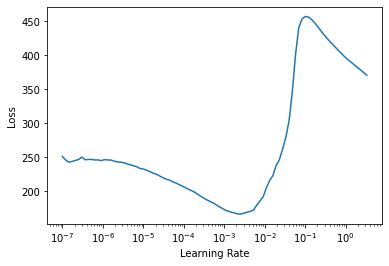

In [135]:
learn.lr_find()

In [141]:
learn.fit_one_cycle(5,0.0003)

epoch,train_loss,valid_loss,time
0,208.705734,361.499725,00:04
1,173.023361,188.644928,00:05
2,142.466309,239.400330,00:06
3,118.517784,184.206055,00:07
4,100.632179,182.441132,00:05


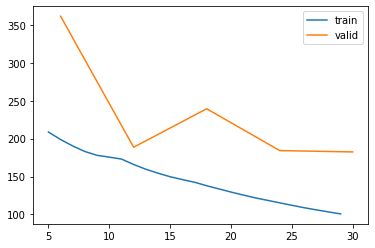

In [142]:
learn.recorder.plot_loss()

In [143]:
preds,targs = learn.get_preds()

In [144]:
mean_absolute_error(targs,preds)

10.631741

In [ ]:
## Model - team based - similar opponents as training data
获取球队最近几场与相似对手交手时，取得的数据作为training data

相似对手：

1. 将ortg和drtg作为x轴y轴，几何距离最近的对手

1. 用什么的ortg，drtg？所有本赛季已进行的比赛的数据？单场？

In [ ]:
## Model - Player based

In [ ]:
# players? -> include minutes played
# injured players?
# use news to guess how many minutes he will play